# Mean heart dose

This notebook demonstrates use of scikit-rt to investigate a possible method for estimating the mean heart dose for a target patient, for whom only a CT image is available, using data from a set of reference patients.  For each reference patient, the data available includes a CT image, a heart outline, and a dose field.

The idea is as follows:
- register one or more reference patients to the target patient;
- for each reference patient considered, use the registration transform to map the heart outline
  and dose field the frame of reference of the target patient;
- estimate the mean heart dose for the target patient from the mapped dose field and mapped heart
  outline.

It's not clear that the above strategy will be very successful.  If a registration is accurate, the distribution of mapped dose within the mapped heart outline for the target patient should be approximately the same as the distribution of dose within the heart outline for the reference patient.  That is, the estimated mean heart dose for the target patient should be approximately the same as the mean heart dose for the reference patient.

This notebook uses the dataset:

Peihan Li, "SPECT_CT_data.zip", Figshare dataset (2020)
https://doi.org/10.6084/m9.figshare.12579707.v1

If not already present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by topdir in the first code cell below. The download file has a size of 1.6 GB, so download may take a while.

## Module import and data download

The following imports modules needed for this example, defines the path to the data directory, downloads the example dataset if not already present, obtains the list of paths to patient folders, and sets some viewer options.

In [1]:
from pathlib import Path
from skrt import set_viewer_options, Defaults, Patient, StructureSet
from skrt.core import download, tic, toc, PathData
from skrt.dose import sum_doses
from skrt.registration import get_parameters
from skrt.segmentation import MultiAtlasSegmentation

## Set paths to directories containing registration software.
engine_dirs = {
    "elastix": "~/sw/elastix-5.0.1-mac"
}

# Set path to directory to be used for registration output.
outdir = "registration_results/synthetic"

# Define whether or not to display user interface, allowing interactive view adjustment.
no_ui = False

# Define URL of source dataset, and local data directory.
url = "https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip"
topdir = Path("~/data/spect_ct").expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)
    
# Obtain sorted list of paths to patient folders.
paths = sorted(list(datadir.glob("0*")))
    
# Set Matplotlib runtime configuration (optional).
set_viewer_options()

# In place of interactive images, display static graphics that can be saved with notebook.
# Defaults().no_ui = True
# Omit user part of paths when printing object attributes.
Defaults().compress_user = True

## Data container

The following defines a class that acts as container for the subset of a patient's data relevant to this analysis.  Using this class, rather than the standard `Patient` class reduces the amount of memory needed, while making the data needed easy to access.

In [2]:
class MiniPatient(PathData):
    """
    Container class for a subset of a patient's data.
    """
    
    def __init__(self, path=None, roi_names=None, voxel_size=None, decimal_places=6):
        """
        Constructor for MiniPatient class.
        
        This constructor aims to extract the following data for a patient:
        
        1. identifier;
        2. sex;
        3. structure set, optionally filtered to contain requested ROIs;
        4. the CT image to which the structure set refers;
        5. the sum of the dose fields associated with the CT image;
        6. the mean heart dose to each reqeusted ROI.
        
        For a given patient, some of these data may be missing.
        
        **Parameters:**
        path: str or pathlib.Path, default=None
            Path to folder containing a patient dataset.
            
        roi_names: dict, default=None
            Dictionary where keys are the names to be assigned to ROIs for which data
            are to be retained, and values are lists of possible names with which the ROIs
            may be labelled in a structure set.  If None, all ROIs in the original structure
            set are retained.
            
        voxel_size: 3-element list or tuple, default=None
            Voxel (x, y, z) dimensions in mm to be used for resampling imaging data.  If any
            dimension is None, its original value is kept.  If <voxel_size> is None, no
            resampling is performed.  A larger voxel size can be useful for reducing
            the amount of memory needed.
            
        decimal_places: int, default=6
            Number of decimal places with which mean dose values are to be stored.
        """
        
        # Create Patient object, and initialise attributes of MiniPatient instance.
        patient = Patient(path, unsorted_dicom=True)
        self.id = patient.id
        self.sex = patient.get_sex()
        self.structure_set = None
        self.ct = None
        self.dose = None
        self.mean_doses = {}
        
        # Obtain structure sets linked to CT images.
        structure_sets = patient.get_structure_sets("ct")
        
        if structure_sets:
            # Check structure sets.
            for structure_set in structure_sets:
                # Filter structure set.
                ss = structure_set.filtered_copy(
                    names=roi_names, keep_renamed_only=True)
                if roi_names is None:
                    roi_names = ss.get_roi_names()
                    
                if len(ss.get_roi_names()) == len(roi_names):
                    # Assign structure set and linked image.
                    self.structure_set = ss
                    self.ct = self.structure_set.get_image()
                    
                    # If image doesn't have linked dose data,
                    # keep looking for one that does.
                    if self.ct and self.ct.get_doses():
                        break
                        
            # Assign structure set as only structure set of image.
            if self.ct is not None:
                self.ct.assign_structure_set(self.structure_set)
          
        # If CT image not assigned via structure set,
        # assign it now, giving preference to image with linked dose data.
        if self.structure_set is None:
            images = patient.get_images("ct")
            for image in images:
                self.ct = image
                if image.get_doses():
                    break
                
        if self.ct:
            # Resample image.
            if voxel_size is not None:
                self.ct.resize(voxel_size=voxel_size)
                
            # Crop image to patient region plus border in mm.
            self.ct.crop(*self.ct.get_foreground_bbox(20))
                
            # Sum any dose arrays, ensuring that they match size of CT image.
            doses = self.ct.get_doses()
            if doses:
                for dose in doses:
                    dose.match_size(self.ct)
                self.dose = sum_doses(doses)
                
            # Calculate mean doses to requested ROIs.
            if self.dose is not None and self.structure_set is not None:
                self.mean_doses = {roi_name: round(self.dose.get_mean_dose(
                    self.structure_set[roi_name]), decimal_places) for roi_name in roi_names}
            
        # Print information on data extracted.
        print(f"{patient.id} ({self.sex}) - has_ct:{self.ct is not None}; "
              + f"has_ss:{self.structure_set is not None}; "
              + f"has_dose:{self.dose is not None}")

        # Free up space in memory of Patient object.
        del patient 

## Data selection

The following selects data for the current analysis.

In [3]:
# Map possible ROI labels to standardised names.
roi_names = {
    "heart": "heart",
}

# Set voxel size.
voxel_size = (4, 4, None)

# Set number of decimal places with which mean dose values are to be stored.
decimal_places = 2

# From previous analysis: identifiers of patients where structure set includes the heart.
has_ss = ['003', '004', '005', '010', '011', '012', '013', '014', '015', '017',
          '018', '019', '023', '024', '025']

# From previous analysis: identifiers of female patients.
# In the test dataset, 2 of 25 patients are female.
is_female = ['019', '023']

# Obtain revised paths to patient data, omitting data for the two female patients,
# and separating paths for datasets with and without a structure set that includes the heart.
# The former provide the reference data, and may be used as target for performance evaluation.
paths_ss = [path for path in paths if path.stem in has_ss and path.stem not in is_female]
paths_noss = [path for path in paths if path.stem not in has_ss and path.stem not in is_female]

# Create MiniPatient objects.
# Initially consider 1 target and 4 reference patients.
tic()
patients = [MiniPatient(path, roi_names, voxel_size, decimal_places) for path in paths_ss[0:5]]
toc("\nTime for data loading: ", ".2f");

target = patients[0]
references = patients[1:]

003 (M) - has_ct:True; has_ss:True; has_dose:True
004 (M) - has_ct:True; has_ss:True; has_dose:True
005 (M) - has_ct:True; has_ss:True; has_dose:True
010 (M) - has_ct:True; has_ss:True; has_dose:True
011 (M) - has_ct:True; has_ss:True; has_dose:True

Time for data loading: 29.12 seconds


## Perform multi-atlas segmentation

The following initiates and runs a multi-atlas segmentation.

In [4]:
tic()

mas = MultiAtlasSegmentation(
    im1=target.ct, # Set image to be segmented.
    im2={patient.id: patient.ct for patient in references}, # Set reference images.
    engine_dir = engine_dirs["elastix"], # Set path to registration software.
    workdir=Path(f"results/{target.id}"), # Set path to patient-specific results.
    roi_names=roi_names, # Set ROIs to be segmented.
    initial_alignment="_top_", # Define initial alignment of target and reference images.
    pfiles1={
        "translation": get_parameters("MI_Translation.txt"),
        "bspline": get_parameters("MI_BSpline15.txt"),
    }, # Define the registration steps.
    auto=True, # Run segmentation immediately following initialisation.
    auto_step="global", # Only run the global registrations, so that transform to be applied to dose.
    default_strategy="pull", # Pull ROI masks from reference images for segmentation.
    overwrite=True, # Overwrite any previous output.
    capture_output=True, # Suppress registration output, which tends to be quite verbosed.
    log_level="WARNING", # Suppress most messages.
)

toc("Time for segmentation: ", ".2f");

Time for segmentation: 76.06 seconds


## Registration results

The following compare the target image and one of the transformed reference images after each step of the registration. 

initial_alignment


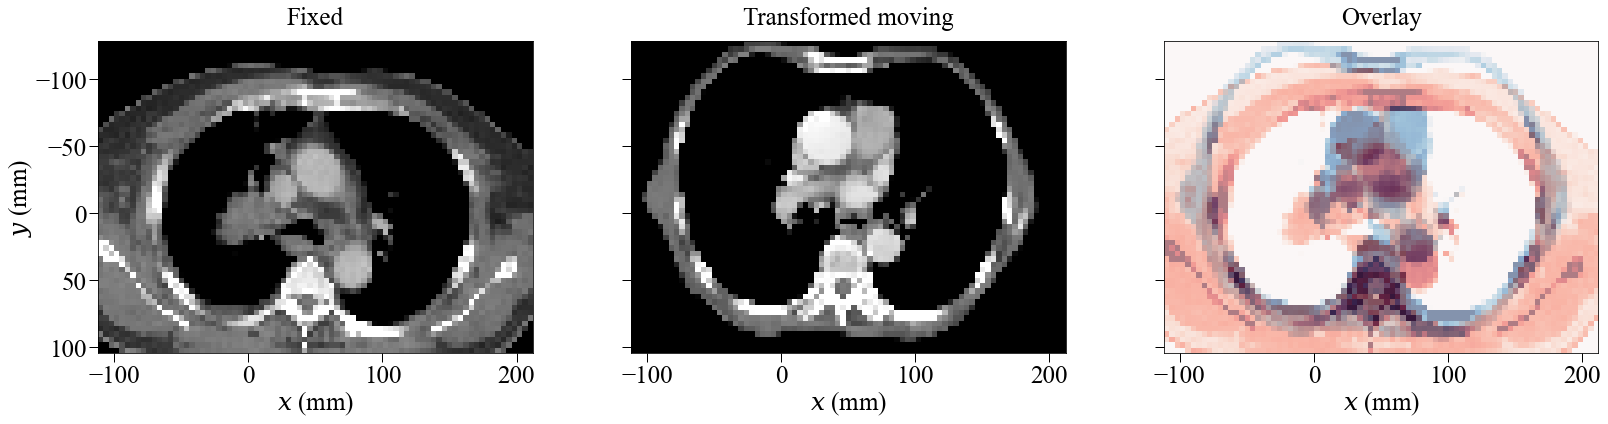

translation


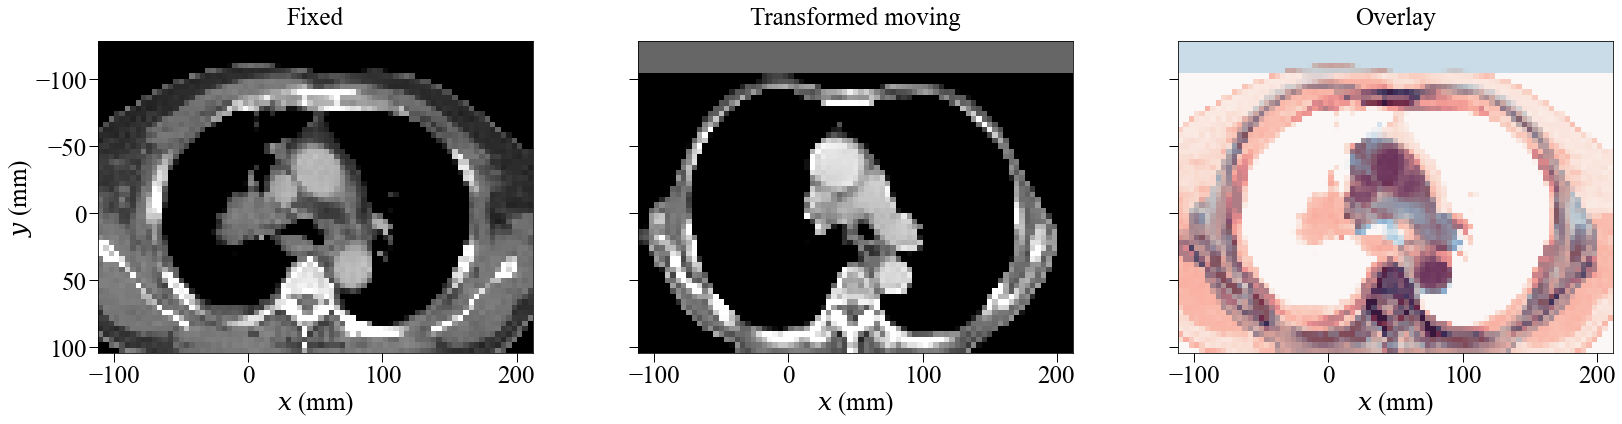

bspline


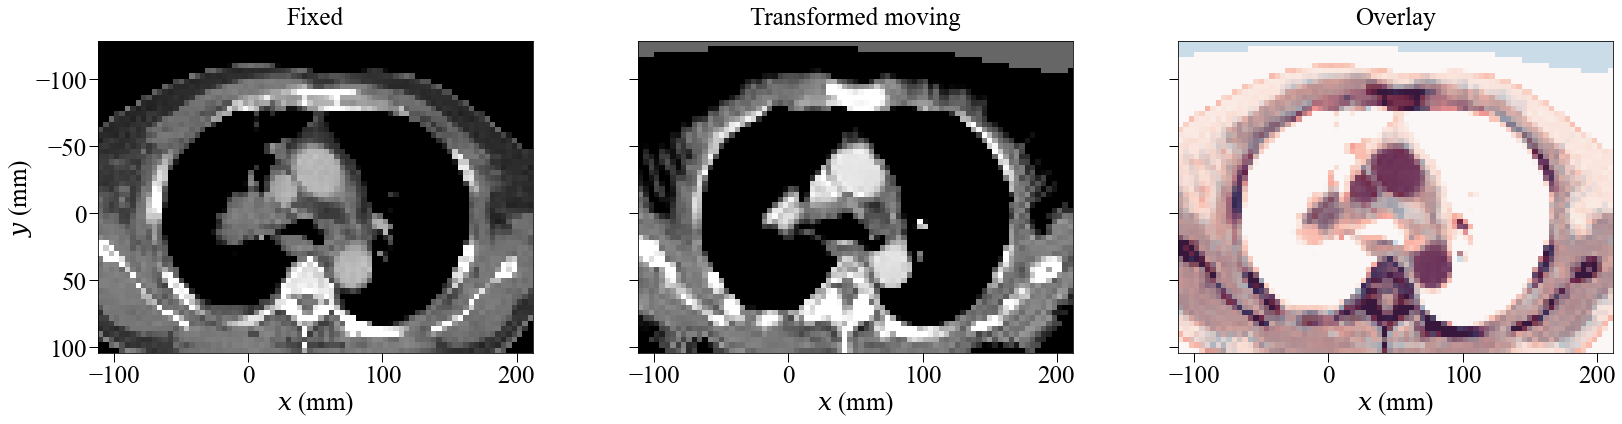

In [5]:
# Show results at each step of registration.
ref_id = references[-1].id
reg = mas.get_sas(ref_id).get_registration()
for reg_step in reg.steps:
    print(reg_step)
    reg.view_result(reg_step)

## Segmentation results

The following compares the segmentations from the different atlases (blue), the consensus result (red), and the manual segmentation of the target (gold).

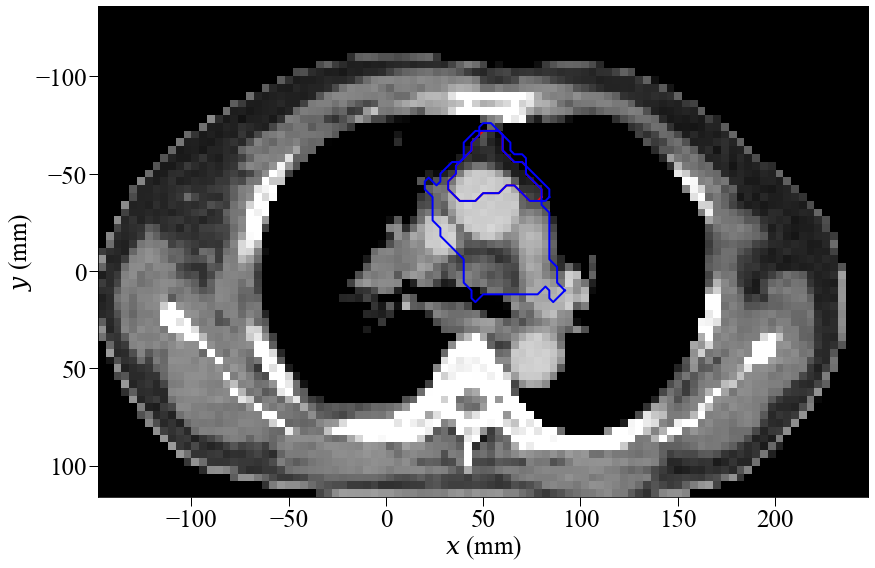

In [6]:
# Collect the atlas results in a single structure sets.
ss2_global = sum([mas.get_sas(idx).get_segmentation() for idx in list(mas.sass)], StructureSet())
for roi in ss2_global: roi.set_color("blue")

# Define structure set for the consensus result.
ss2_consensus = mas.get_consensus(consensus_type="staple")
for roi in ss2_consensus: roi.set_color("red")

# Set colour for the manual segmentation of the target.
ss1_filtered = mas.get_sas().ss1_filtered or StructureSet()
for roi in ss1_filtered: roi.set_color("gold")

# Collect together all structure sets, and set the image to be the target image.
rois = ss1_filtered + ss2_global + ss2_consensus
rois.set_image(mas.im1)

# Display results
mas.im1.view(rois=rois, legend=False, init_view="x-y", figsize=8, zoom=1);

The following summarises Dice scores for atlas-based segmentations compared with manual segmentation, following each registration step.

In [7]:
df1 = mas.get_comparison(to_keep="heart", atlas_ids_to_compare=True, consensus_types="staple",
                         metrics="dice", strategies=None, steps=None, reg_steps=True, id1=target.id)
print(df1);
# Optionally save results to file.
# df1.to_csv("multiatlas.csv", index=False)

      ROI      dice  id1                     id2 strategy    step  \
0   heart  0.449595  003                     005     pull  global   
1   heart  0.696901  003                     005     pull  global   
2   heart  0.817782  003                     005     pull  global   
3   heart  0.782005  003                     010     pull  global   
4   heart  0.710814  003                     010     pull  global   
5   heart  0.842607  003                     010     pull  global   
6   heart  0.462698  003                     004     pull  global   
7   heart  0.532198  003                     004     pull  global   
8   heart  0.691318  003                     004     pull  global   
9   heart  0.472355  003                     011     pull  global   
10  heart  0.557716  003                     011     pull  global   
11  heart  0.780478  003                     011     pull  global   
12  heart  0.507502  003  004_005_010_011_staple     pull  global   
13  heart  0.710376  003  004_005_

## Dose transformations

The following applies registration transforms to each reference dose, and estimates resulting ROI mean dose for the target.

In [8]:
# Add to target MiniPatient object dictionaries for mapped doses.
target.ref_doses = {}
target.mean_ref_doses = {}

for ref in references:
    if ref.dose is not None:
        # Obtain SingleAtlasSegmentation object for current reference patient.
        sas = mas.get_sas(ref.id)
        
        # Apply registration transform to map reference dose to target frame of reference. 
        dose = sas.get_registration().transform(ref.dose).astype("dcm")
        dose.match_size(target.ct)
        target.ref_doses[ref.id] = dose
        
        # Estimate ROI mean doses.
        target.mean_ref_doses[ref.id] = {}
        for roi_name in roi_names:
            target.mean_ref_doses[ref.id][roi_name] = round(target.ref_doses[ref.id].get_mean_dose(
                sas.get_segmentation()[roi_name]), decimal_places)

The following displays each reference dose along side the mapping to the target CT image.  Initial views are for the central `x-y` slice, which tends not to be the same anatomical position for reference and target.  Anatomies can be aligned by scrolling through the images.

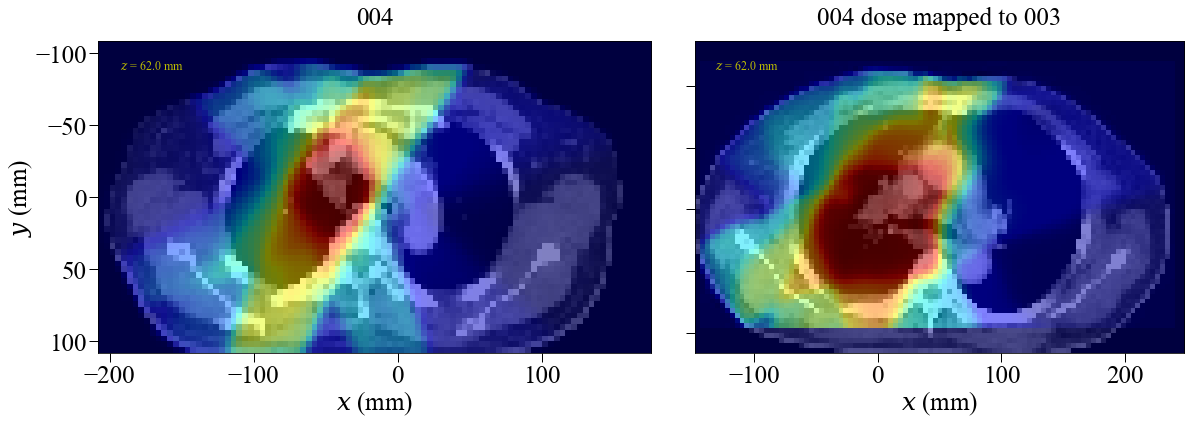

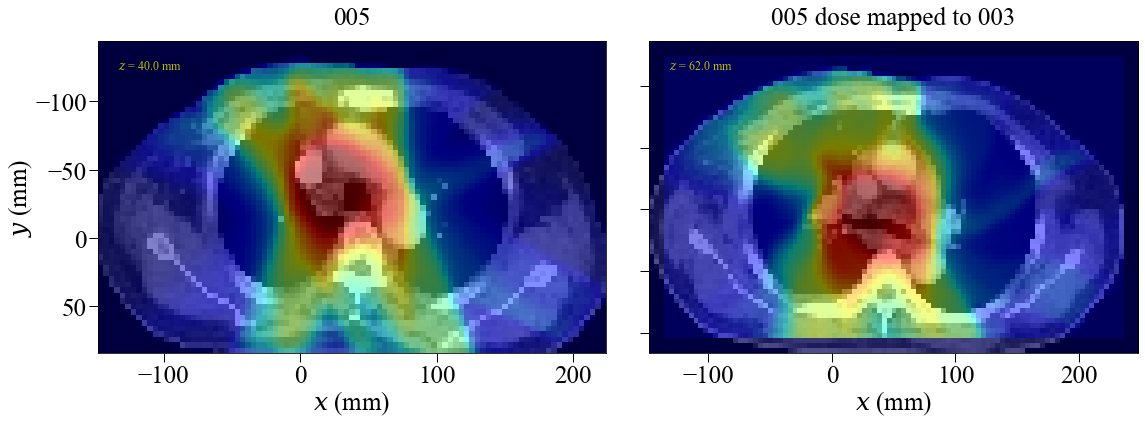

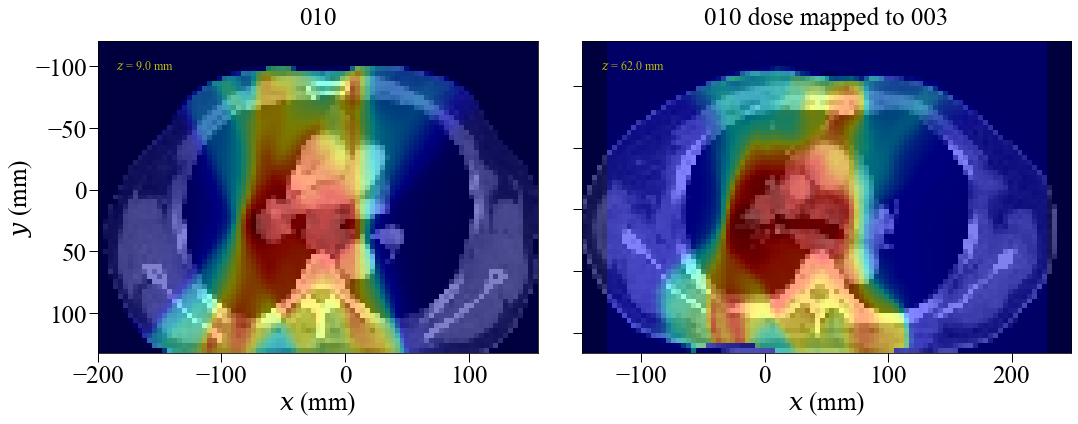

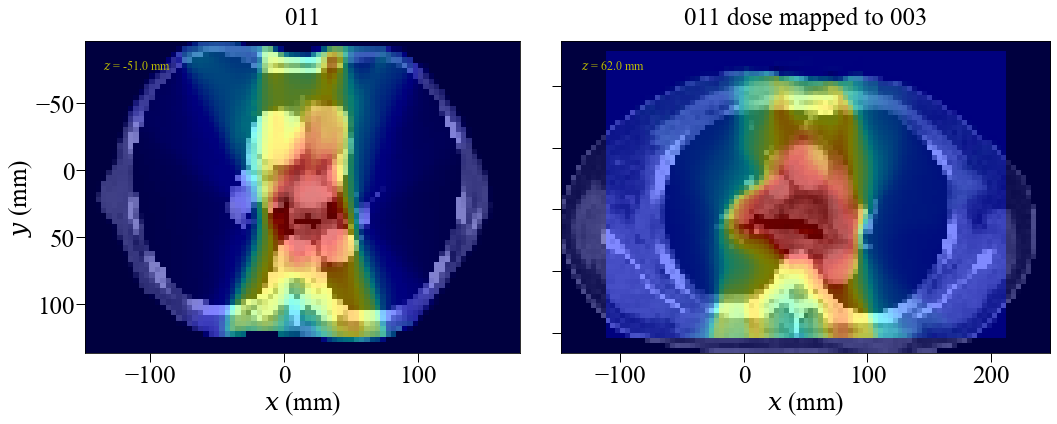

In [9]:
# Display reference doses and their mappings.
for ref in references:
    ref.ct.view(images=target.ct, dose=[ref.dose, target.ref_doses[ref.id]],
                 title=[ref.id, f"{ref.id} dose mapped to {target.id}"], annotate_slice="y")

ROI mean doses

The following summarises information about mean doses to the heart.  Individual values are plan dependent.  Mean doses to the target estimated from mapping the reference doses tend to correlate with the reference mean doses.

In [10]:
print("Target:")
print(f"  {target.id}: {target.mean_doses}")
print("\nReferences mapped to target:")
for ref_id in target.mean_ref_doses:
    print(f"  {ref_id}: {target.mean_ref_doses[ref_id]}")
print("\nReferences:")
for ref in references:
    print(f"  {ref.id}: {ref.mean_doses}")

Target:
  003: {'heart': 13.69}

References mapped to target:
  004: {'heart': 7.16}
  005: {'heart': 12.02}
  010: {'heart': 19.22}
  011: {'heart': 36.61}

References:
  004: {'heart': 7.3}
  005: {'heart': 9.52}
  010: {'heart': 19.86}
  011: {'heart': 39.63}
